In [ ]:
import kagglehub

path = kagglehub.dataset_download("rumethsandinu/neobreath")
print("Path to dataset files:", path)

100%|██████████| 6.82G/6.82G [05:18<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rumethsandinu/neobreath-pet/versions/1


In [2]:
import torch

In [ ]:
CONFIG = {
    'data_dir': '/root/.cache/kagglehub/datasets/rumethsandinu/neobreath/versions/1/PET/up_threshold_0.8',

    # A: Adenocarcinoma, B: Small Cell Carcinoma, G: Squamous Cell Carcinoma
    'classes': ['A', 'B', 'G'],
    'image_size': 128,
    'seq_length': 8,
    'grad_accum': 1,

    'epochs': 60,
    'patience': 20,             # epochs without val loss improvement before stop
    'batch_size': 16,
    'lr': 2e-4,
    'weight_decay': 0.01,
    'save_every': 5,
    'eval_every': 1,
    'inference_steps': 50,      # DDPM sampling steps (fast) for periodic eval

    # model architecture
    'channels': (64, 128, 256)
    'timesteps': 1000,
    'prediction_type': 'v_prediction',
    'use_fp16': True,

    # EMA
    'ema_decay': 0.999,
    'ema_start': 5,

    # load last checkpoint
    'last_ckpt': None
}

# device detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print('\nConfigurations:')
    print(f"Image size: {CONFIG['image_size']}×{CONFIG['image_size']}")
    print(f"Sequence length: {CONFIG['seq_length']} frames")
    print(f"Batch size: {CONFIG['batch_size']} (per forward pass)")
    print(f"Effective batch size: {CONFIG['batch_size'] * CONFIG['grad_accum']}")
    print(f"Model channels: {CONFIG['channels']}")
    est_mb = (CONFIG['batch_size'] * CONFIG['seq_length'] * CONFIG['image_size'] * CONFIG['image_size'] * 2 / 1e6)
    print(f"Approx input activations per batch (fp16): ~{est_mb:.1f} MB")
else:
    print("No GPU detected")

Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB

Configurations:
Image size: 128×128
Sequence length: 8 frames
Batch size: 16 (per forward pass)
Effective batch size: 16
Model channels: (64, 128, 256)
Approx input activations per batch (fp16): ~4.2 MB


In [4]:
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from pathlib import Path
import torchvision.transforms.functional as TF

# set reproducability
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
class PETDataset(Dataset):
    """
    Custom Dataset for loading PET slice sequences with slice-wise data augmentation.

    Steps:
    1. Splits volumes into fixed-length (seq_len) sequences.
    2. Optionally creates an augmented copy of each full sequence by applying
       conservative, medically-aware augmentations slice-wise.
    3. Resizes to target image_size and returns tensors normalized to [-1, 1]
       ready for a class-conditional DDPM.

    Args:
        data_dir (str or Path): Directory with class subfolders containing .npy files.
        classes (list[str]): List of class folder names (e.g. ['A','B','G']).
        seq_len (int): Number of slices per sequence (default: 8).
        image_size (int): Target H=W for training (default: 200).
        augment (bool): Whether to create augmented copies (default: True).
        augment_times (int): How many augmented copies to create per sequence.
    """

    def __init__(self, data_dir, classes, seq_len=8, image_size=128, augment=True, augment_times=1):
        self.data_dir = Path(data_dir)
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.seq_len = int(seq_len)
        self.image_size = int(image_size)
        self.augment = bool(augment)
        self.augment_times = max(1, int(augment_times))

        # store sequences
        self.sequences = []
        self.skipped_seq = 0

        # load all sequences
        for cls in classes:
            cls_dir = self.data_dir / cls
            if not cls_dir.exists():
                print(f'Data directory for {cls} does not exist')
                continue

            for npy_file in sorted(cls_dir.glob("*.npy")):
                # shape (N, H, W) in range [0, 1]
                vol = np.load(npy_file)

                # only take seq_len chunks. Discard what remains.
                # no padding to train the model for original data.
                n_full = vol.shape[0] // self.seq_len
                if n_full == 0:
                    continue

                for i in range(n_full):
                    start = i * self.seq_len
                    chunk = vol[start:start + self.seq_len]

                    # defensive check: ensure correct shape
                    if chunk.shape[0] != self.seq_len:
                        continue

                    # store original (non-augmented)
                    self.sequences.append((chunk.astype(np.float32), self.class_to_idx[cls], False))

                    # optionally create augmented copies (slice-wise augmentation)
                    if self.augment:
                        for _ in range(self.augment_times):
                            aug_chunk = np.stack([self._augment_slice(s) for s in chunk])
                            self.sequences.append((aug_chunk.astype(np.float32), self.class_to_idx[cls], True))

        # print simple dataset stats for quick verification
        total = len(self.sequences)
        print(f"Loaded {total} sequences (including augmented copies)")
        for cls in classes:
            count = sum(1 for _, lbl, _ in self.sequences if lbl == self.class_to_idx[cls])
            pct = (count/total*100) if total else 0
            print(f"Class {cls}: {count} sequences ({pct:.1f}%)")

    def _augment_slice(self, slice_np):
        """
        Apply conservative, medically-aware augmentations to a single 2D slice.

        Augmentations (~50% probability):
          1. Horizontal flip
          2. Vertical flip
          3. Small rotation (±10 degrees)
          4. Small brightness scaling (0.9 - 1.1)

        Geometric deformation that changes voxel spacing is avoided.
        """

        t = torch.from_numpy(slice_np).unsqueeze(0)

        # horizontal flip
        if random.random() > 0.5:
            t = TF.hflip(t)

        # vertical flip
        if random.random() > 0.5:
            t = TF.vflip(t)

        # rotation ±10 degrees
        if random.random() > 0.5:
            angle = random.uniform(-10, 10)
            t = TF.rotate(t, angle, interpolation=InterpolationMode.BILINEAR)

        # brightness adjust 0.9 - 1.1
        if random.random() > 0.5:
            factor = random.uniform(0.9, 1.1)
            t = TF.adjust_brightness(t, factor)

        out = t.squeeze(0).numpy()

        # clip back to [0,1] in case small numerical excursions occurred
        out = np.clip(out, 0.0, 1.0)
        return out

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, cls_idx, is_aug = self.sequences[idx]

        # normalize to [-1, 1] (DDPM input convention)
        seq = seq.astype(np.float32) * 2.0 - 1.0

        # convert to PyTorch tensor with channel dim: (seq_len, 1, H, W)
        tensor_seq = torch.from_numpy(seq).unsqueeze(1)

        # resize if needed to (T, 1, image_size, image_size)
        _, _, H, W = tensor_seq.shape
        if (H, W) != (self.image_size, self.image_size):
            tensor_seq = torch.nn.functional.interpolate(
                tensor_seq, size=(self.image_size, self.image_size), mode='bilinear', align_corners=False
            )

        return tensor_seq, torch.tensor(cls_idx, dtype=torch.long)


dataset = PETDataset(
    data_dir=CONFIG['data_dir'],
    classes=CONFIG['classes'],
    seq_len=CONFIG['seq_length'],
    image_size=CONFIG['image_size'],
    augment=True,
    augment_times=1
)

dataloader = DataLoader(
    dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=False
)

print(f"\nAugmentation Technique: {'Enabled (slice-wise)' if dataset.augment else 'Disabled'}")

Loaded 2902 sequences (including augmented copies)
Class A: 2292 sequences (79.0%)
Class B: 126 sequences (4.3%)
Class G: 484 sequences (16.7%)

Augmentation Technique: Enabled (slice-wise)


In [6]:
import matplotlib.pyplot as plt
import json
from torch.utils.data import Subset, DataLoader as _DL

In [7]:
# train/test split after augmentation with balanced sampling capability

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
cls_to_indices = {c: [] for c in range(len(CONFIG['classes']))}
for idx, (_seq, lbl, _is_aug) in enumerate(dataset.sequences):
    cls_to_indices[int(lbl)].append(idx)

train_indices, test_indices = [], []
class_split_counts = {}
for cls_idx, idx_list in cls_to_indices.items():
    shuffled = idx_list[:]
    random.shuffle(shuffled)
    n = len(shuffled)
    n_train = int(round(0.8 * n))
    n_train = min(max(0, n_train), max(0, n - 1)) if n > 1 else n
    tr = shuffled[:n_train]
    te = shuffled[n_train:]
    train_indices.extend(tr)
    test_indices.extend(te)
    class_split_counts[idx_to_class[cls_idx]] = {"total": n, "train": len(tr), "test": len(te)}

from torch.utils.data import Subset, WeightedRandomSampler
train_dataset = Subset(dataset, sorted(train_indices))
test_dataset = Subset(dataset, sorted(test_indices))

# compute class weights inverse to frequency for balanced sampling
train_labels = []
for local_idx in train_dataset.indices:
    _, lbl, _ = dataset.sequences[local_idx]
    train_labels.append(int(lbl))
class_counts = np.bincount(train_labels, minlength=len(CONFIG['classes']))
class_weights = 1.0 / (class_counts + 1e-6)
weights = [class_weights[lbl] for lbl in train_labels]

sampler = WeightedRandomSampler(weights, num_samples=len(train_labels), replacement=True)

train_dataloader = _DL(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    sampler=sampler,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=False
)

test_dataloader = _DL(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=False
)

print("Split summary (after augmentation):")
import json
print(json.dumps(class_split_counts, indent=2))
print(f"Train sequences: {len(train_dataset)} | Test sequences: {len(test_dataset)} | Total: {len(dataset)}")
print("Class counts (train):", class_counts.tolist())
print("Class weights:", [round(w, 4) for w in class_weights.tolist()])

split_path = 'split_seed42_aug_80_20_balanced.json'
with open(split_path, 'w') as f:
    json.dump({
        "seed": 42,
        "rule": "per-class 80/20 after augmentation + weighted sampler",
        "class_counts": class_split_counts,
        "train_indices": sorted(train_indices),
        "test_indices": sorted(test_indices),
        "class_weights": class_weights.tolist(),
    }, f, indent=2)
print(f"Saved split file: {split_path}")

Split summary (after augmentation):
{
  "A": {
    "total": 2292,
    "train": 1834,
    "test": 458
  },
  "B": {
    "total": 126,
    "train": 101,
    "test": 25
  },
  "G": {
    "total": 484,
    "train": 387,
    "test": 97
  }
}
Train sequences: 2322 | Test sequences: 580 | Total: 2902
Class counts (train): [1834, 101, 387]
Class weights: [0.0005, 0.0099, 0.0026]
Saved split file: split_seed42_aug_80_20_balanced.json


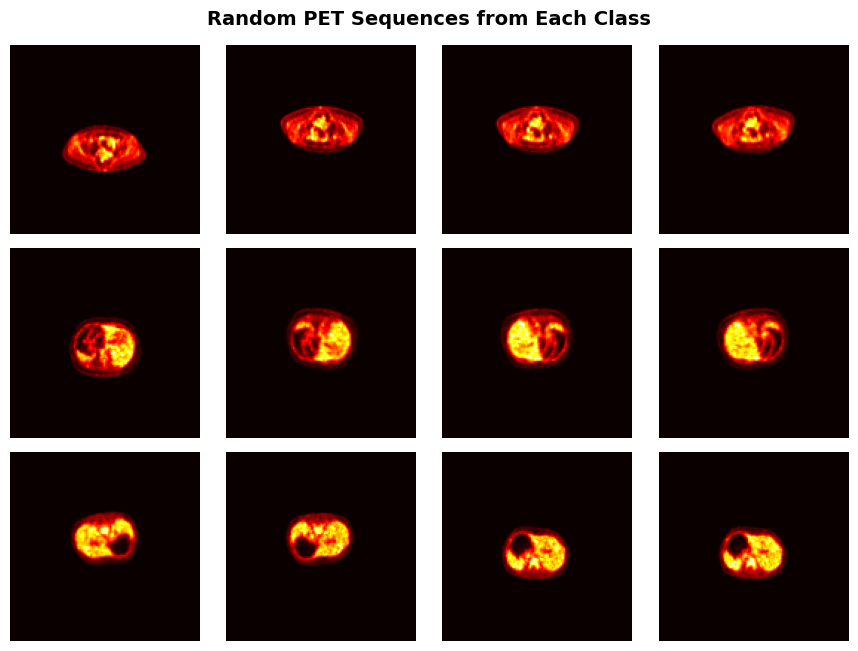

In [8]:
# pick one random sequence per class
samples = []
slices_per_seq = 4
for cls_idx, cls in enumerate(CONFIG['classes']):

    # find indices of this class
    indices = [i for i, (_, lbl, _) in enumerate(dataset.sequences) if lbl == cls_idx]
    if len(indices) == 0:
        print(f"No samples found for class {cls}")
        continue
    idx = random.choice(indices)
    seq, label = dataset[idx]
    samples.append((cls, seq[0: slices_per_seq]))

# visualize
n_rows = len(samples)
n_cols = slices_per_seq
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2 * n_cols, 2.2 * n_rows), squeeze=False)

for r, (cls, seq) in enumerate(samples):
    seq = (seq.squeeze(1) + 1) / 2  # [-1,1] → [0,1]
    for c in range(slices_per_seq):
        axes[r, c].imshow(seq[c], cmap='hot')
        axes[r, c].axis('off')
    axes[r, 0].set_ylabel(cls, fontsize=12, fontweight='bold')

plt.suptitle("Random PET Sequences from Each Class", fontsize=14, fontweight='bold')
plt.tight_layout()
plot_path = f"preprocssed_pet_sequences.jpg"
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

In [9]:
from diffusers import UNet2DModel, DDPMScheduler

In [10]:
# UNet2D Model (3 stages for 128x128)
# Architecture: Encoder-Decoder with skip connections

model = UNet2DModel(
    sample_size=CONFIG['image_size'],
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=CONFIG['channels'],

    # encoder (keep attention in the middle resolution)
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),

    # decoder
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),

    # class conditioning
    class_embed_type="timestep",
    num_class_embeds=len(CONFIG['classes']),

).to(device)

# DDPM Scheduler (cosine + v-prediction)
scheduler = DDPMScheduler(
    num_train_timesteps=CONFIG['timesteps'],
    beta_schedule="squaredcos_cap_v2",
    prediction_type=CONFIG['prediction_type']
)

# optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['lr'],
    weight_decay=CONFIG['weight_decay'],
    betas=(0.9, 0.999)
)

# model stats
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = total_params * 2 / 1e6

print(f"Architecture: UNet2D (3 stages) with class conditioning + attention")
print(f"Trainable parameters: {trainable_params/1e6:.2f}M")
print(f"Approx model size (fp16): {model_size_mb:.1f} MB")

Architecture: UNet2D (3 stages) with class conditioning + attention
Trainable parameters: 14.82M
Approx model size (fp16): 29.6 MB


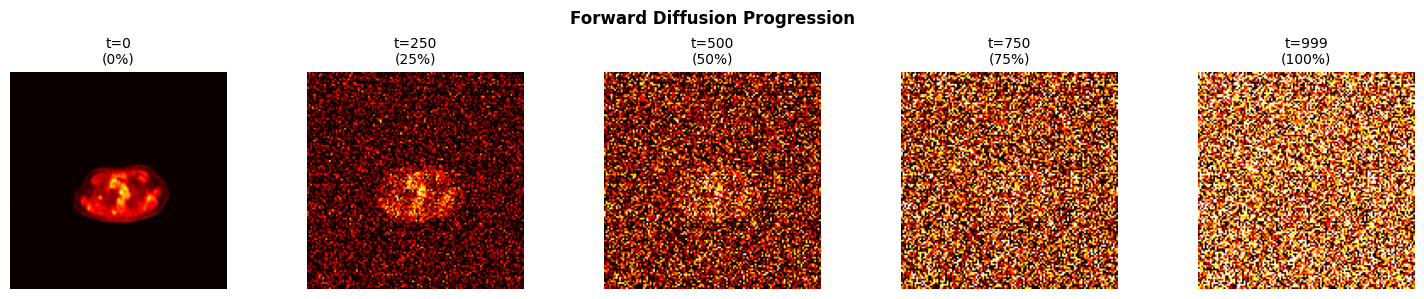

Saved noise progression figure (noise_progression.jpg) and tensor (noise_progression.pt)


In [11]:
# forward diffusion noise progression visualization (single, cleaned version)
import matplotlib.pyplot as plt

try:
    first_batch = next(iter(train_dataloader))
    seqs, labels = first_batch
except StopIteration:
    raise RuntimeError("Train dataloader is empty – cannot visualize noise progression.")

# select first sequence's first frame (channel already 1) in [-1,1]
img0 = seqs[0, 0].unsqueeze(0).to(device)  # (1,1,H,W)

# fixed noise for reproducibility
noise = torch.randn_like(img0)

T = int(CONFIG['timesteps'])
# pick 5 representative timesteps: 0, 25, 50, 75, 100
show_ts = [0, T//4, T//2, 3*T//4, T-1]
show_ts = sorted(set(show_ts))

noised_imgs = []
with torch.no_grad():
    for t in show_ts:
        ts = torch.tensor([t], dtype=torch.long, device=device)
        xt = scheduler.add_noise(img0, noise, ts)  # q(x_t|x_0)
        noised_imgs.append(xt.squeeze(0).detach().cpu())  # (1,H,W)

# plot
num_cols = len(noised_imgs)
fig, axes = plt.subplots(1, num_cols, figsize=(3 * num_cols, 3), squeeze=False)
for i, (t, x_t) in enumerate(zip(show_ts, noised_imgs)):
    vis = (x_t + 1) / 2  # map [-1,1] -> [0,1]
    vis = vis.clamp(0, 1)
    axes[0, i].imshow(vis[0], cmap='hot', vmin=0, vmax=1)
    axes[0, i].axis('off')
    pct = 100 * t / (T - 1)
    axes[0, i].set_title(f"t={t}\n({pct:.0f}%)", fontsize=10)

plt.suptitle("Forward Diffusion Progression", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('noise_progression.jpg', dpi=150, bbox_inches='tight')
plt.show()

# optionally store tensor stack for later analysis
progress_tensor = torch.stack(noised_imgs)  # (len(show_ts), 1, H, W)
torch.save({'timesteps': show_ts, 'samples': progress_tensor}, 'noise_progression.pt')
print("Saved noise progression figure (noise_progression.jpg) and tensor (noise_progression.pt)")

In [12]:
import os

In [13]:
# resume from checkpoint if provided and dry-run forward pass ---
start_epoch = 0

if CONFIG.get('last_ckpt'):
    ckpt_path = str(CONFIG['last_ckpt'])
    if os.path.exists(ckpt_path):
        print(f"Checkpoint: {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)

        # load model and optimizer states if present
        if isinstance(ckpt, dict):
            if 'model' in ckpt:
                model.load_state_dict(ckpt['model'])
                print("Loaded model state_dict.")
            if 'optimizer' in ckpt:
                try:
                    optimizer.load_state_dict(ckpt['optimizer'])
                    print("Loaded optimizer state_dict.")
                except Exception as e:
                    print(f"Warning: could not load optimizer state: {e}")
            if 'ema' in ckpt and isinstance(ckpt['ema'], dict):
                ema.shadow = ckpt['ema']
                print("Loaded EMA shadow weights.")
            if 'epoch' in ckpt:
                start_epoch = int(ckpt['epoch'])
                print(f"Resuming from epoch index {start_epoch}.")
            if 'loss' in ckpt:
                resume_last_loss = float(ckpt['loss'])
        else:
            print("Unexpected checkpoint format (expected dict). Proceeding without resume.")

        # dry-run forward pass (no grad) to verify shapes without updating gradients
        try:
            model.eval()
            with torch.no_grad():
                try:
                    batch = next(iter(train_dataloader))
                    seqs, labels = batch
                    B, T, C, H, W = seqs.shape
                    imgs = seqs.view(-1, C, H, W).to(device)
                    labels_flat = labels.unsqueeze(1).repeat(1, T).view(-1).to(device)
                except Exception:
                    # fallback to synthetic input
                    B = max(1, int(CONFIG.get('batch_size', 1)))
                    T = int(CONFIG.get('seq_length', 8))
                    H = W = int(CONFIG.get('image_size', 200))
                    imgs = torch.randn(B*T, 1, H, W, device=device)
                    labels_flat = torch.zeros(B*T, dtype=torch.long, device=device)

                noise = torch.randn_like(imgs)
                timesteps = torch.randint(0, CONFIG['timesteps'], (imgs.shape[0],), device=device)
                noisy = scheduler.add_noise(imgs, noise, timesteps)

                out = model(noisy, timesteps, class_labels=labels_flat)
                print(f"Dry-run forward: output.sample shape = {tuple(out.sample.shape)}")
        except Exception as e:
            print(f"Dry-run forward failed: {e}")
        finally:
            model.train()
    else:
        print(f"Configured last_ckpt not found: {ckpt_path}")
else:
    print("No last_ckpt configured. Starting from scratch.")

No last_ckpt configured. Starting from scratch.


In [14]:
import gc

In [15]:
if torch.cuda.is_available():

    # clear cached memory
    torch.cuda.empty_cache()
    gc.collect()

    # check current GPU memory usage
    allocated = torch.cuda.memory_allocated() / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    available = total - allocated

    print(f"Allocated: {allocated:.2f} GB")
    print(f"Available: {available:.2f} GB")

else:
    print("No GPU detected — training will run on CPU")

Allocated: 0.06 GB
Available: 85.11 GB


In [16]:
from torch.amp import autocast

In [17]:
# exponential Moving Average (EMA) for better sample fidelity
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = float(decay)
        self.shadow = {}
        self.collected = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.detach().clone()

    @torch.no_grad()
    def update(self, model):
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            assert name in self.shadow
            new_average = (1.0 - self.decay) * param.detach() + self.decay * self.shadow[name]
            self.shadow[name] = new_average.clone()

    @torch.no_grad()
    def copy_to(self, model):
        for name, param in model.named_parameters():
            if not param.requires_grad:
                continue
            assert name in self.shadow
            param.data.copy_(self.shadow[name].data)

# create EMA wrapper for the training model
epochs_before_ema = int(CONFIG['ema_start'])
ema = EMA(model, decay=CONFIG['ema_decay'])


In [18]:
def generate(model, scheduler, class_idx, n_samples=4, n_frames=8, use_ema=True):
    """
    Generate synthetic samples for a given class using current or EMA weights.
    Returns a tensor of shape (n_samples, n_frames, 1, H, W) in [-1, 1].
    """
    model.eval()
    start_time = time.time()

    # optionally copy EMA weights into a temporary model
    restore_state = None
    if use_ema:
        restore_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    with torch.no_grad():
        total = n_samples * n_frames
        x = torch.randn(total, 1, CONFIG['image_size'], CONFIG['image_size'], device=device)
        labels = torch.full((total,), class_idx, device=device, dtype=torch.long)

        # set sampling schedule to fewer steps for speed
        scheduler.set_timesteps(CONFIG['inference_steps'])

        progress_bar = tqdm(scheduler.timesteps, desc=f"Sampling {CONFIG['classes'][class_idx]}", leave=True)
        for t in progress_bar:
            ts = torch.full((total,), t, device=device, dtype=torch.long)
            with autocast(device_type=device.type, enabled=CONFIG['use_fp16']):
                pred = model(x, ts, class_labels=labels).sample
            x = scheduler.step(pred, t, x).prev_sample

    # restore original weights if EMA was used
    if use_ema and restore_state is not None:
        model.load_state_dict(restore_state)

    if device.type == 'cuda':
        torch.cuda.empty_cache()

    model.train()
    print(f"Generation completed for class '{CONFIG['classes'][class_idx]}' in {(time.time() - start_time)/60:.1f} min")

    return x.view(n_samples, n_frames, 1, CONFIG['image_size'], CONFIG['image_size'])

In [19]:
from torch.amp import GradScaler
import time
from tqdm import tqdm
import torch.nn.functional as F

# metrics: diversity, SSIM, pixel_diff (MAE)
import math
import torch
import torch.nn.functional as F

try:
    from skimage.metrics import structural_similarity as skimage_ssim
    _HAS_SKIMAGE = True
except Exception:
    _HAS_SKIMAGE = False


def _to_01(x: torch.Tensor) -> torch.Tensor:
    """Ensure tensor image(s) are in [0,1]. Input can be [-1,1] or [0,1].
    Accepts shapes (N, H, W) or (N, 1, H, W) or (H, W). Returns float32 on CPU.
    """
    if isinstance(x, torch.Tensor):
        t = x.detach()
    else:
        t = torch.as_tensor(x)
    t = t.float()
    # squeeze channel if single
    if t.ndim == 4 and t.size(1) == 1:
        t = t.squeeze(1)
    # map from [-1,1] -> [0,1] if clearly outside [0,1]
    tmin, tmax = t.min().item(), t.max().item()
    if tmin < -0.2 or tmax > 1.2:
        t = (t + 1.0) / 2.0
    return t.clamp(0.0, 1.0).cpu()


def compute_diversity(gen_imgs: torch.Tensor) -> float:
    """Average pairwise L1 distance in pixel space, normalized to [0,1].
    gen_imgs: (N, H, W) or (N, 1, H, W) or (N, C=1, H, W)
    Returns a scalar float.
    """
    x = _to_01(gen_imgs)  # (N, H, W)
    # single image -> no diversity
    if x.ndim == 2:
        return 0.0
    N = x.shape[0]
    if N < 2:
        return 0.0
    H, W = x.shape[-2], x.shape[-1]
    flat = x.view(N, -1)  # (N, H*W)

    # pairwise L1 distances; use cdist with p=1 for simplicity
    with torch.no_grad():
        dists = torch.cdist(flat, flat, p=1)

        # exclude diagonal and duplicates by taking upper triangle only
        iu = torch.triu_indices(N, N, offset=1)
        mean_l1 = dists[iu[0], iu[1]].mean().item()

        # normalize by number of pixels (max L1 per pair in [0,1] space is H*W)
        norm = float(H * W)
        return float(mean_l1 / (norm + 1e-8))


# minimal torch SSIM fallback (single-channel, 2D)
def _torch_ssim(img1: torch.Tensor, img2: torch.Tensor) -> float:
    # expects (H, W) in [0,1]
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    x = img1.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    y = img2.unsqueeze(0).unsqueeze(0)

    # simple 3x3 average window to keep it lightweight
    kernel = torch.ones((1, 1, 3, 3), dtype=x.dtype) / 9.0
    mu_x = F.conv2d(x, kernel, padding=1)
    mu_y = F.conv2d(y, kernel, padding=1)
    mu_x2 = mu_x.pow(2)
    mu_y2 = mu_y.pow(2)
    mu_xy = mu_x * mu_y
    sigma_x2 = F.conv2d(x * x, kernel, padding=1) - mu_x2
    sigma_y2 = F.conv2d(y * y, kernel, padding=1) - mu_y2
    sigma_xy = F.conv2d(x * y, kernel, padding=1) - mu_xy
    ssim_map = ((2 * mu_xy + C1) * (2 * sigma_xy + C2)) / ((mu_x2 + mu_y2 + C1) * (sigma_x2 + sigma_y2 + C2) + 1e-8)
    return float(ssim_map.mean().item())


def compute_ssim(gen_imgs: torch.Tensor, real_imgs: torch.Tensor, max_pairs: int = 32) -> float:
    """Mean SSIM between generated and real images.
    Matches up to max_pairs images by random pairing. Inputs in any of (N,H,W),(N,1,H,W).
    Returns mean SSIM in [0,1].
    """
    g = _to_01(gen_imgs)
    r = _to_01(real_imgs)
    Ng, Nr = g.shape[0], r.shape[0]
    if Ng == 0 or Nr == 0:
        return 0.0
    n = int(min(max_pairs, Ng, Nr))

    # deterministic pairing with local generator (no global RNG side-effects)
    ggen = torch.Generator().manual_seed(0)
    rgen = torch.Generator().manual_seed(0)
    idx_g = torch.randperm(Ng, generator=ggen)[:n]
    idx_r = torch.randperm(Nr, generator=rgen)[:n]
    g = g[idx_g]
    r = r[idx_r]
    scores = []
    for i in range(n):
        gi = g[i]
        ri = r[i]
        if _HAS_SKIMAGE:
            try:
                val = skimage_ssim(gi.numpy(), ri.numpy(), data_range=1.0)
            except Exception:
                val = _torch_ssim(gi, ri)
        else:
            val = _torch_ssim(gi, ri)

        # clamp to [0,1]
        scores.append(max(0.0, min(1.0, float(val))))
    return float(sum(scores) / len(scores))


def compute_pixel_diff(gen_imgs: torch.Tensor, real_imgs: torch.Tensor, max_pairs: int = 32) -> float:
    """Mean Absolute Error between generated and real images in [0,1].
    Pairs up to max_pairs images. Returns scalar in [0,1].
    """
    g = _to_01(gen_imgs)
    r = _to_01(real_imgs)
    Ng, Nr = g.shape[0], r.shape[0]
    if Ng == 0 or Nr == 0:
        return 0.0
    n = int(min(max_pairs, Ng, Nr))
    gen = torch.Generator().manual_seed(0)
    idx_g = torch.randperm(Ng, generator=gen)[:n]
    idx_r = torch.randperm(Nr, generator=gen)[:n]
    g = g[idx_g]
    r = r[idx_r]
    with torch.no_grad():
        mae = (g - r).abs().mean().item()
    return float(mae)


In [20]:
scaler = GradScaler(enabled=CONFIG['use_fp16'])
losses = []
best_loss = float('inf')
no_improve = 0

# metrics history
diversity_scores = []
pixel_diffs = []
ssim_scores = []
improvement = []

log_path = "training_log.txt"
if not os.path.exists(log_path):
    with open(log_path, 'w') as f:
        f.write("epoch,loss,improvement,diversity,pixel_diff,ssim,time_min\n")

# training loop
for epoch in range(start_epoch, CONFIG['epochs']):
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
    start_time = time.time()

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")
    for i, (seqs, labels) in enumerate(pbar):
        B, T, C, H, W = seqs.shape
        imgs = seqs.view(-1, C, H, W).to(device)
        labels_flat = labels.unsqueeze(1).repeat(1, T).view(-1).to(device)

        noise = torch.randn_like(imgs)
        timesteps = torch.randint(0, CONFIG['timesteps'], (imgs.shape[0],), device=device)
        noisy = scheduler.add_noise(imgs, noise, timesteps)

        with autocast(device_type=device.type, enabled=CONFIG['use_fp16']):
            output = model(noisy, timesteps, class_labels=labels_flat)
            pred = output.sample
            if CONFIG['prediction_type'] == 'v_prediction':
                target = scheduler.get_velocity(imgs, noise, timesteps)
            else:
                target = noise
            loss = F.mse_loss(pred, target) / CONFIG['grad_accum']

        scaler.scale(loss).backward()

        if (i + 1) % CONFIG['grad_accum'] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # EMA update after a few warmup epochs
            if (epoch + 1) >= CONFIG['ema_start']:
                ema.update(model)

        epoch_loss += loss.item() * CONFIG['grad_accum']
        pbar.set_postfix({'loss': f'{loss.item() * CONFIG["grad_accum"]:.4f}'})

    avg_loss = epoch_loss / max(1, len(train_dataloader))
    losses.append(avg_loss)
    elapsed = time.time() - start_time

    # improvement
    if len(losses) < 2:
        improvement.append(0.0)
        no_improve = 0
    else:
        delta = losses[-2] - avg_loss
        improvement.append(delta)
        if delta > 0.0:
            no_improve = 0
        else:
            no_improve += 1

    # save best
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'ema': ema.shadow,
            'config': CONFIG,
            'epoch': epoch + 1,
            'loss': avg_loss
        }, "best.pt")
        print(f"\nBest model updated: loss={best_loss:.4f}")

    # lightweight evaluation every eval_every epochs
    do_eval = ((epoch + 1) % CONFIG['eval_every'] == 0) or ((epoch + 1) == CONFIG['epochs'])
    if do_eval:
        model.eval()
        generated = {}
        class_diversity = []
        class_pixel_diff = []
        class_ssim = []

        # collect one full pass of test images to ensure minority classes appear
        all_real_imgs = []
        all_real_labels = []
        for rseqs, rlabels in test_dataloader:
            all_real_imgs.append(rseqs)
            all_real_labels.append(rlabels)
        real_seqs = torch.cat(all_real_imgs, dim=0).to(device)
        real_labels = torch.cat(all_real_labels, dim=0).to(device)
        RH, RW = real_seqs.shape[-2], real_seqs.shape[-1]

        with torch.no_grad():
            for cls_idx, cls in enumerate(CONFIG['classes']):
                samples = generate(model, scheduler, class_idx=cls_idx,
                                   n_samples=min(4, CONFIG['batch_size']),
                                   n_frames=CONFIG['seq_length'], use_ema=True)
                generated[cls] = samples  # (N, T, 1, H, W)

                # flatten to image list for metrics
                gen_imgs = samples.view(-1, 1, RH, RW)  # (N*T, 1, H, W)

                # diversity (within generated set), normalized [0,1]
                div_val = compute_diversity(gen_imgs)
                class_diversity.append(div_val)

                # gather real images of this class from full real set
                mask = (real_labels == cls_idx)
                if mask.sum() > 0:
                    real_imgs = real_seqs[mask].view(-1, 1, RH, RW)
                else:
                    real_imgs = real_seqs.view(-1, 1, RH, RW)

                # pixel difference (MAE) and SSIM against real
                pdiff = compute_pixel_diff(gen_imgs, real_imgs)
                ssim_val = compute_ssim(gen_imgs, real_imgs)

                class_pixel_diff.append(pdiff)
                class_ssim.append(ssim_val)

        diversity_scores.append(class_diversity)
        pixel_diffs.append(class_pixel_diff)
        ssim_scores.append(class_ssim)

        print(
            f"Epoch {epoch+1}: loss={avg_loss:.4f}, "
            f"improv={improvement[-1]:.4f}, "
            f"diversity={[round(d,4) for d in class_diversity]}, "
            f"pixel_diff={[round(p,4) for p in class_pixel_diff]}, "
            f"ssim={[round(s,4) for s in class_ssim]}, "
            f"time={elapsed/60:.1f}min"
        )

        with open(log_path, 'a') as f:
            f.write(
                f"{epoch+1},{avg_loss:.4f},{improvement[-1]:.4f},"
                f"{[round(d,4) for d in class_diversity]},"
                f"{[round(p,4) for p in class_pixel_diff]},"
                f"{[round(s,4) for s in class_ssim]},{elapsed/60:.2f}\n"
            )

        # save periodic checkpoint
        if (epoch + 1) % CONFIG['save_every'] == 0 or ((epoch + 1) == CONFIG['epochs']):
            ckpt_path = f"ckpt_ep{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'ema': ema.shadow,
                'loss': avg_loss,
                'config': CONFIG,
            }, ckpt_path)
            print(f"checkpoint saved: {ckpt_path}")

    # early stopping
    if no_improve >= CONFIG['patience']:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {CONFIG['patience']} epochs).")
        break

print(f"\nFinal loss: {losses[-1]:.4f}, Best loss: {best_loss:.4f}")
print(f"Training log saved at: {log_path}")

Epoch 1/60: 100%|██████████| 146/146 [03:01<00:00,  1.24s/it, loss=0.0206]



Best model updated: loss=0.0405


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.77it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 1: loss=0.0405, improv=0.0000, diversity=[0.4166, 0.4166, 0.4168], pixel_diff=[0.4318, 0.431, 0.4291], ssim=[0.0004, 0.0002, 0.0005], time=3.0min


Epoch 2/60: 100%|██████████| 146/146 [02:58<00:00,  1.22s/it, loss=0.0028]



Best model updated: loss=0.0100


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 2: loss=0.0100, improv=0.0305, diversity=[0.4167, 0.4164, 0.4167], pixel_diff=[0.4318, 0.432, 0.4285], ssim=[0.0003, 0.0002, 0.0004], time=3.0min


Epoch 3/60: 100%|██████████| 146/146 [02:58<00:00,  1.22s/it, loss=0.0042]



Best model updated: loss=0.0085


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 3: loss=0.0085, improv=0.0015, diversity=[0.417, 0.4165, 0.4164], pixel_diff=[0.4317, 0.4317, 0.4278], ssim=[0.0003, 0.0002, 0.0005], time=3.0min


Epoch 4/60: 100%|██████████| 146/146 [02:58<00:00,  1.22s/it, loss=0.0079]



Best model updated: loss=0.0080


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 4: loss=0.0080, improv=0.0005, diversity=[0.4165, 0.4166, 0.4169], pixel_diff=[0.432, 0.4314, 0.4287], ssim=[0.0004, 0.0003, 0.0004], time=3.0min


Epoch 5/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0129]



Best model updated: loss=0.0074


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 5: loss=0.0074, improv=0.0006, diversity=[0.2504, 0.251, 0.2517], pixel_diff=[0.2131, 0.2162, 0.2176], ssim=[0.0008, 0.0006, 0.0012], time=3.0min
checkpoint saved: ckpt_ep5.pt


Epoch 6/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0105]



Best model updated: loss=0.0070


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 6: loss=0.0070, improv=0.0004, diversity=[0.1014, 0.1018, 0.1022], pixel_diff=[0.1028, 0.1067, 0.111], ssim=[0.0074, 0.0059, 0.0077], time=3.0min


Epoch 7/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0029]



Best model updated: loss=0.0069


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 7: loss=0.0069, improv=0.0001, diversity=[0.0416, 0.0415, 0.042], pixel_diff=[0.0577, 0.0616, 0.0682], ssim=[0.0401, 0.0379, 0.0387], time=3.0min


Epoch 8/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0031]



Best model updated: loss=0.0069


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 8: loss=0.0069, improv=0.0000, diversity=[0.0179, 0.0182, 0.0184], pixel_diff=[0.0373, 0.0416, 0.0491], ssim=[0.1135, 0.1116, 0.1067], time=3.0min


Epoch 9/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0071]



Best model updated: loss=0.0066


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 9: loss=0.0066, improv=0.0003, diversity=[0.008, 0.0076, 0.0083], pixel_diff=[0.0288, 0.0325, 0.0409], ssim=[0.1921, 0.1985, 0.1831], time=3.0min


Epoch 10/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0032]



Best model updated: loss=0.0065


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 10: loss=0.0065, improv=0.0000, diversity=[0.0043, 0.0042, 0.0047], pixel_diff=[0.0254, 0.0291, 0.0381], ssim=[0.2403, 0.2417, 0.2287], time=3.0min
checkpoint saved: ckpt_ep10.pt


Epoch 11/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0057]



Best model updated: loss=0.0065


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 11: loss=0.0065, improv=0.0001, diversity=[0.0037, 0.0036, 0.0048], pixel_diff=[0.0233, 0.0266, 0.0357], ssim=[0.2811, 0.2945, 0.2721], time=3.0min


Epoch 12/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0012]



Best model updated: loss=0.0063


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 12: loss=0.0063, improv=0.0002, diversity=[0.003, 0.0039, 0.0038], pixel_diff=[0.0215, 0.0245, 0.0345], ssim=[0.3212, 0.3436, 0.3002], time=3.0min


Epoch 13/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0012]



Best model updated: loss=0.0059


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 13: loss=0.0059, improv=0.0004, diversity=[0.0034, 0.004, 0.0055], pixel_diff=[0.0203, 0.0231, 0.0318], ssim=[0.3645, 0.387, 0.3639], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 14: loss=0.0062, improv=-0.0002, diversity=[0.0043, 0.0053, 0.0049], pixel_diff=[0.019, 0.021, 0.0314], ssim=[0.4252, 0.4626, 0.4085], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 15: loss=0.0062, improv=-0.0000, diversity=[0.0041, 0.0034, 0.0073], pixel_diff=[0.0174, 0.0206, 0.0294], ssim=[0.4944, 0.5096, 0.468], time=3.0min
checkpoint saved: ckpt_ep15.pt


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 16: loss=0.0062, improv=-0.0000, diversity=[0.0041, 0.0035, 0.0092], pixel_diff=[0.016, 0.0188, 0.0279], ssim=[0.5634, 0.5775, 0.5755], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 17: loss=0.0061, improv=0.0001, diversity=[0.0043, 0.0055, 0.0049], pixel_diff=[0.0149, 0.0171, 0.0266], ssim=[0.6134, 0.6472, 0.614], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 18: loss=0.0060, improv=0.0001, diversity=[0.0066, 0.0085, 0.0137], pixel_diff=[0.0137, 0.0178, 0.0268], ssim=[0.7002, 0.6933, 0.6731], time=3.0min


Epoch 19/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0097]



Best model updated: loss=0.0059


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 19: loss=0.0059, improv=0.0001, diversity=[0.0047, 0.0058, 0.0106], pixel_diff=[0.0132, 0.0168, 0.0251], ssim=[0.6951, 0.7291, 0.697], time=3.0min


Epoch 20/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0009]



Best model updated: loss=0.0057


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 20: loss=0.0057, improv=0.0002, diversity=[0.0055, 0.0062, 0.0127], pixel_diff=[0.0137, 0.0161, 0.0253], ssim=[0.7387, 0.7387, 0.7191], time=3.0min
checkpoint saved: ckpt_ep20.pt


Epoch 21/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0027]



Best model updated: loss=0.0056


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 21: loss=0.0056, improv=0.0001, diversity=[0.006, 0.0082, 0.0136], pixel_diff=[0.0131, 0.0166, 0.0231], ssim=[0.7464, 0.7631, 0.7735], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 22: loss=0.0056, improv=-0.0001, diversity=[0.0096, 0.0078, 0.0127], pixel_diff=[0.0149, 0.0157, 0.0261], ssim=[0.7789, 0.814, 0.7641], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 23: loss=0.0056, improv=0.0001, diversity=[0.0064, 0.0075, 0.0142], pixel_diff=[0.0125, 0.0148, 0.0228], ssim=[0.7985, 0.8492, 0.7903], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 24: loss=0.0056, improv=-0.0000, diversity=[0.007, 0.0116, 0.0178], pixel_diff=[0.0111, 0.0166, 0.0242], ssim=[0.8155, 0.8446, 0.7834], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 25: loss=0.0057, improv=-0.0001, diversity=[0.0082, 0.01, 0.015], pixel_diff=[0.0121, 0.0153, 0.0229], ssim=[0.8071, 0.8043, 0.8028], time=3.0min
checkpoint saved: ckpt_ep25.pt


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 26: loss=0.0056, improv=0.0001, diversity=[0.0079, 0.0093, 0.015], pixel_diff=[0.012, 0.016, 0.0226], ssim=[0.8521, 0.8615, 0.8202], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 27: loss=0.0057, improv=-0.0001, diversity=[0.011, 0.011, 0.0178], pixel_diff=[0.0131, 0.0145, 0.0223], ssim=[0.8232, 0.8533, 0.8241], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 28: loss=0.0057, improv=0.0001, diversity=[0.0096, 0.0082, 0.014], pixel_diff=[0.0125, 0.0149, 0.0274], ssim=[0.85, 0.8657, 0.8259], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 29: loss=0.0057, improv=-0.0000, diversity=[0.0066, 0.0093, 0.0155], pixel_diff=[0.0118, 0.014, 0.0245], ssim=[0.8395, 0.8766, 0.8122], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 30: loss=0.0056, improv=0.0001, diversity=[0.0118, 0.0083, 0.0148], pixel_diff=[0.0114, 0.0156, 0.0247], ssim=[0.8533, 0.866, 0.8139], time=3.0min
checkpoint saved: ckpt_ep30.pt


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 31: loss=0.0056, improv=0.0001, diversity=[0.008, 0.0121, 0.0188], pixel_diff=[0.0119, 0.0163, 0.0232], ssim=[0.8432, 0.8586, 0.838], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 32: loss=0.0056, improv=-0.0001, diversity=[0.0081, 0.0106, 0.0191], pixel_diff=[0.0123, 0.0148, 0.0232], ssim=[0.8614, 0.8479, 0.8192], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 33: loss=0.0056, improv=0.0001, diversity=[0.0082, 0.0129, 0.0148], pixel_diff=[0.0113, 0.0169, 0.0219], ssim=[0.8543, 0.8549, 0.8385], time=3.0min


Epoch 34/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0039]



Best model updated: loss=0.0054


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 34: loss=0.0054, improv=0.0001, diversity=[0.0099, 0.0085, 0.0175], pixel_diff=[0.011, 0.0149, 0.0226], ssim=[0.8666, 0.8898, 0.8217], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 35: loss=0.0056, improv=-0.0002, diversity=[0.0078, 0.0106, 0.0203], pixel_diff=[0.0119, 0.0165, 0.0216], ssim=[0.8601, 0.8597, 0.8393], time=3.0min
checkpoint saved: ckpt_ep35.pt


Epoch 36/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0009]



Best model updated: loss=0.0052


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 36: loss=0.0052, improv=0.0004, diversity=[0.0121, 0.0109, 0.0165], pixel_diff=[0.014, 0.0154, 0.0222], ssim=[0.8404, 0.8544, 0.812], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 37: loss=0.0054, improv=-0.0002, diversity=[0.0081, 0.0081, 0.017], pixel_diff=[0.0107, 0.0145, 0.0213], ssim=[0.8495, 0.8571, 0.842], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 38: loss=0.0053, improv=0.0002, diversity=[0.0089, 0.0112, 0.0188], pixel_diff=[0.0123, 0.015, 0.0221], ssim=[0.8588, 0.8759, 0.8122], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 39: loss=0.0054, improv=-0.0001, diversity=[0.0082, 0.013, 0.0179], pixel_diff=[0.0108, 0.015, 0.0245], ssim=[0.8603, 0.8541, 0.8283], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 40: loss=0.0055, improv=-0.0001, diversity=[0.011, 0.0101, 0.0204], pixel_diff=[0.0135, 0.0158, 0.0265], ssim=[0.8574, 0.8565, 0.8201], time=3.0min
checkpoint saved: ckpt_ep40.pt


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 41: loss=0.0054, improv=0.0001, diversity=[0.0109, 0.0102, 0.0164], pixel_diff=[0.0114, 0.0163, 0.0245], ssim=[0.8496, 0.8759, 0.8091], time=3.0min


Epoch 42/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0014]



Best model updated: loss=0.0051


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 42: loss=0.0051, improv=0.0003, diversity=[0.0103, 0.0116, 0.0171], pixel_diff=[0.0137, 0.0158, 0.025], ssim=[0.8563, 0.8708, 0.8258], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 43: loss=0.0052, improv=-0.0001, diversity=[0.0104, 0.013, 0.0225], pixel_diff=[0.0121, 0.017, 0.0259], ssim=[0.8532, 0.8409, 0.8317], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 44: loss=0.0052, improv=0.0001, diversity=[0.0092, 0.0076, 0.0188], pixel_diff=[0.012, 0.0154, 0.0256], ssim=[0.8686, 0.8949, 0.8249], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 45: loss=0.0051, improv=0.0000, diversity=[0.0088, 0.0114, 0.0184], pixel_diff=[0.012, 0.0166, 0.0238], ssim=[0.8392, 0.8786, 0.8137], time=3.0min
checkpoint saved: ckpt_ep45.pt


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 46: loss=0.0053, improv=-0.0002, diversity=[0.0092, 0.0062, 0.0208], pixel_diff=[0.0114, 0.0134, 0.0258], ssim=[0.8572, 0.8732, 0.8197], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 47: loss=0.0053, improv=-0.0000, diversity=[0.011, 0.0089, 0.0188], pixel_diff=[0.0134, 0.0143, 0.0248], ssim=[0.8614, 0.8982, 0.8313], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 48: loss=0.0053, improv=-0.0000, diversity=[0.0067, 0.0078, 0.0224], pixel_diff=[0.0114, 0.0144, 0.0253], ssim=[0.8631, 0.8866, 0.808], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 49: loss=0.0051, improv=0.0002, diversity=[0.0088, 0.0141, 0.0161], pixel_diff=[0.0122, 0.0144, 0.022], ssim=[0.8601, 0.8632, 0.8416], time=3.0min


Epoch 50/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0099]



Best model updated: loss=0.0050


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 50: loss=0.0050, improv=0.0001, diversity=[0.0126, 0.0143, 0.0184], pixel_diff=[0.0135, 0.017, 0.0246], ssim=[0.8394, 0.8936, 0.8469], time=3.0min
checkpoint saved: ckpt_ep50.pt


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 51: loss=0.0052, improv=-0.0002, diversity=[0.0132, 0.0078, 0.018], pixel_diff=[0.0132, 0.0152, 0.0229], ssim=[0.8585, 0.8767, 0.8307], time=3.0min


Epoch 52/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0083]



Best model updated: loss=0.0048


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 52: loss=0.0048, improv=0.0003, diversity=[0.0096, 0.0113, 0.0193], pixel_diff=[0.0114, 0.0149, 0.0223], ssim=[0.8691, 0.8764, 0.8289], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 53: loss=0.0051, improv=-0.0003, diversity=[0.0103, 0.0085, 0.0195], pixel_diff=[0.0139, 0.0158, 0.0229], ssim=[0.8522, 0.8583, 0.832], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 54: loss=0.0051, improv=0.0000, diversity=[0.0141, 0.0071, 0.0199], pixel_diff=[0.0146, 0.013, 0.0234], ssim=[0.8553, 0.8818, 0.8364], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 55: loss=0.0052, improv=-0.0001, diversity=[0.0103, 0.0114, 0.0192], pixel_diff=[0.0125, 0.0174, 0.0229], ssim=[0.862, 0.8873, 0.8396], time=3.0min
checkpoint saved: ckpt_ep55.pt


Epoch 56/60: 100%|██████████| 146/146 [03:00<00:00,  1.24s/it, loss=0.0070]



Best model updated: loss=0.0048


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 56: loss=0.0048, improv=0.0004, diversity=[0.0154, 0.0109, 0.0193], pixel_diff=[0.0148, 0.0178, 0.0236], ssim=[0.8718, 0.8619, 0.8423], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 57: loss=0.0049, improv=-0.0001, diversity=[0.0105, 0.0067, 0.0169], pixel_diff=[0.0121, 0.0139, 0.0222], ssim=[0.8553, 0.8896, 0.8467], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 58: loss=0.0050, improv=-0.0001, diversity=[0.0126, 0.0104, 0.0195], pixel_diff=[0.0132, 0.0159, 0.0231], ssim=[0.8714, 0.8819, 0.8289], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 59: loss=0.0049, improv=0.0001, diversity=[0.0113, 0.0108, 0.02], pixel_diff=[0.012, 0.015, 0.0239], ssim=[0.851, 0.8896, 0.8162], time=3.0min


Sampling A: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'A' in 0.1 min


Sampling B: 100%|██████████| 50/50 [00:05<00:00,  9.87it/s]


Generation completed for class 'B' in 0.1 min


Sampling G: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Generation completed for class 'G' in 0.1 min
Epoch 60: loss=0.0051, improv=-0.0002, diversity=[0.0135, 0.012, 0.0207], pixel_diff=[0.013, 0.0162, 0.0238], ssim=[0.8734, 0.8956, 0.8392], time=3.0min
checkpoint saved: ckpt_ep60.pt

Final loss: 0.0051, Best loss: 0.0048
Training log saved at: training_log.txt


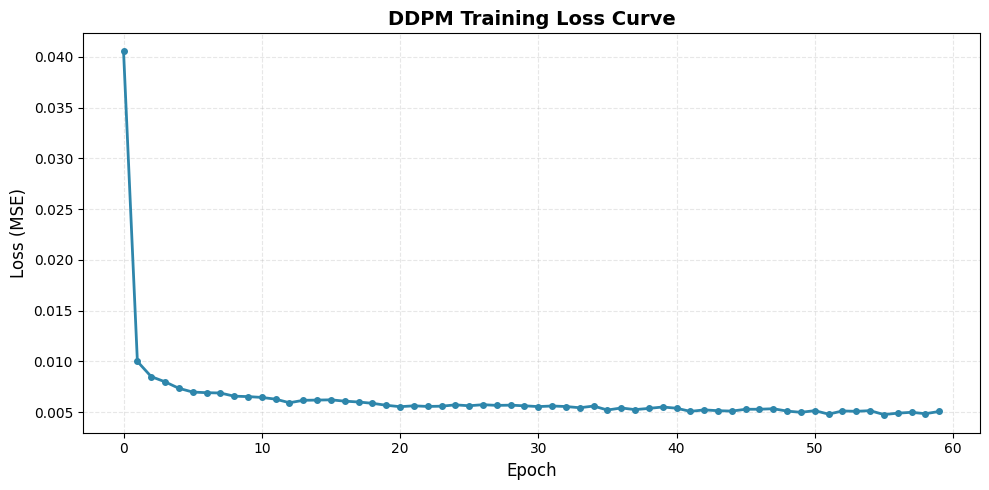

Initial loss: 0.0405
Final loss: 0.0051
Best loss: 0.0048 @ epoch 56
Worst loss: 0.0405 @ epoch 1


In [21]:
# loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2, color='#2E86AB', marker='o', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('DDPM Training Loss Curve', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')

plt.show()

# print statistics
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Best loss: {min(losses):.4f} @ epoch {losses.index(min(losses))+1}")
print(f"Worst loss: {max(losses):.4f} @ epoch {losses.index(max(losses))+1}")

  Class A: torch.Size([8, 128, 128])
  Class B: torch.Size([8, 128, 128])
  Class G: torch.Size([8, 128, 128])


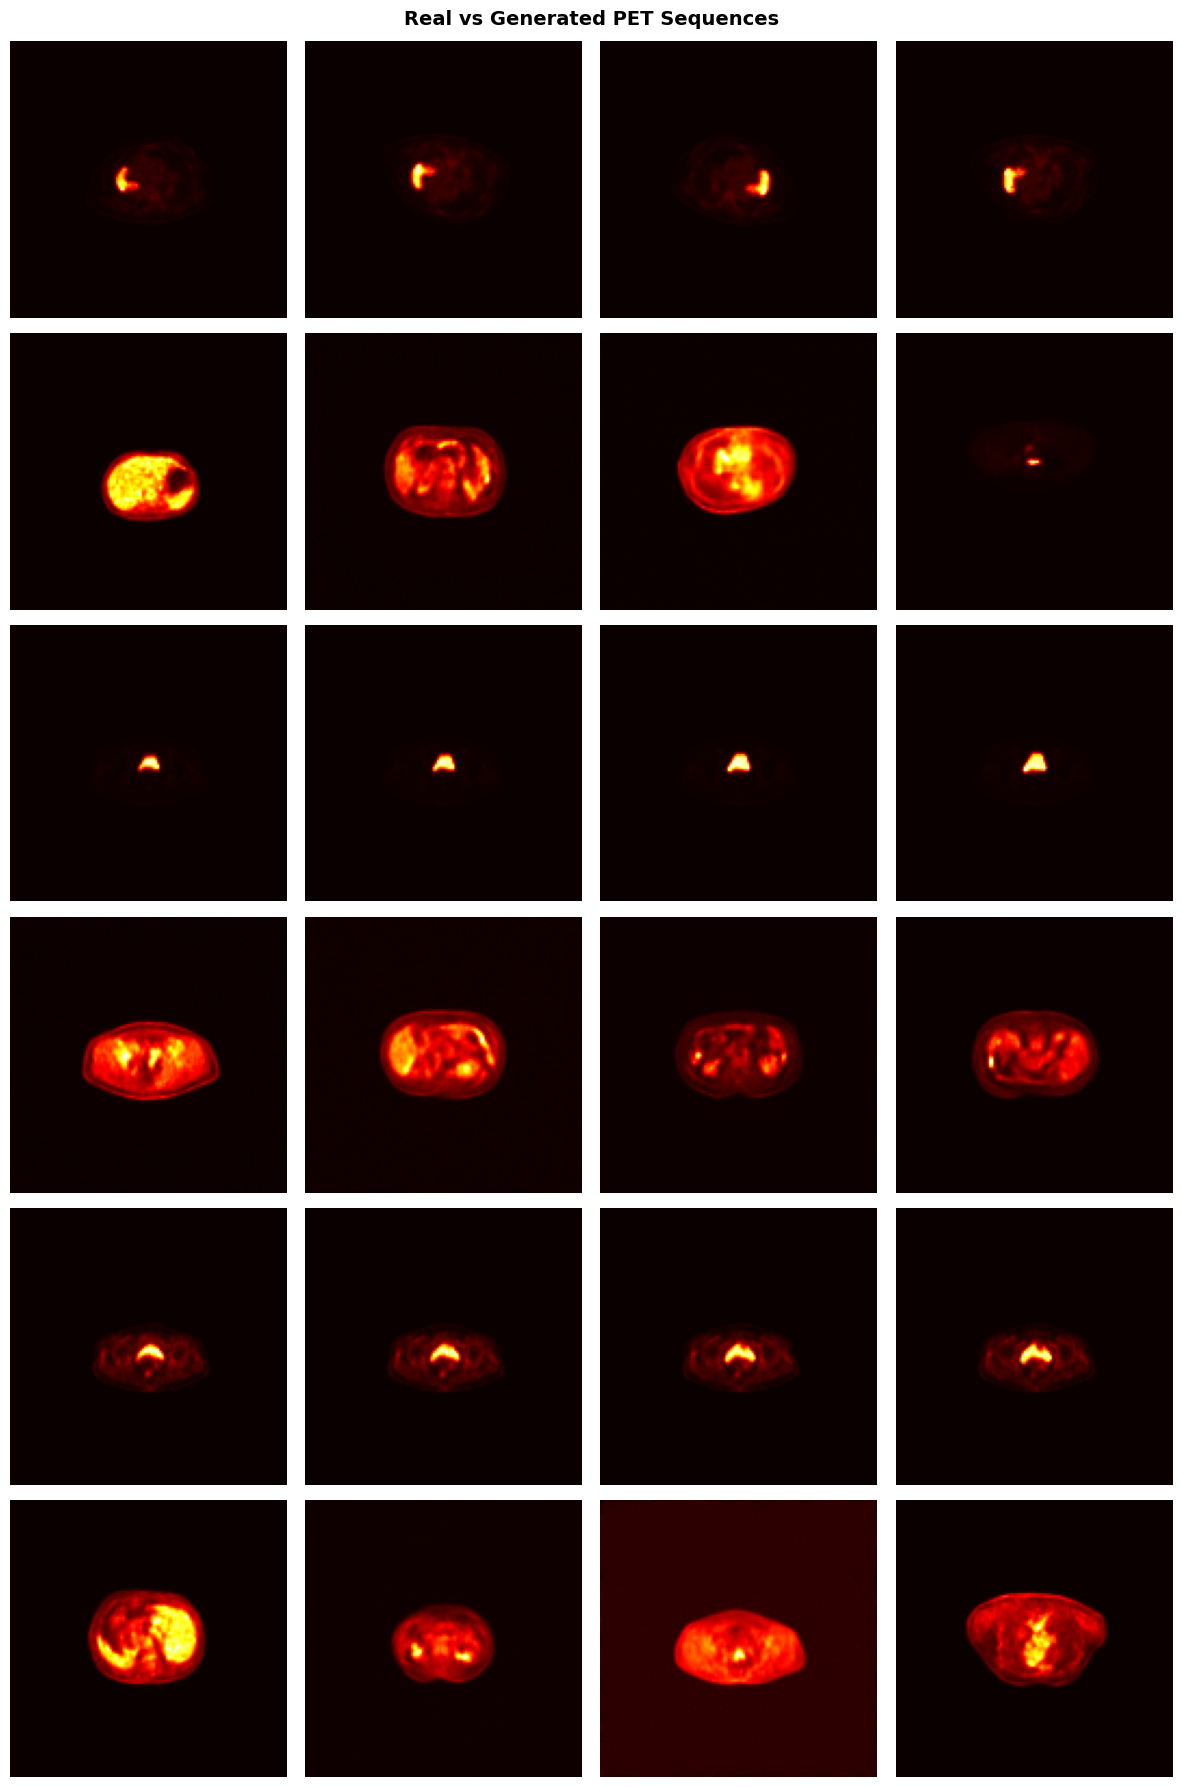

In [24]:
# extract real samples and compare
# load best checkpoint and generate a small batch per class using EMA.
if 'generated' not in globals():
    print("No in-memory generated samples found. Loading best.pt for quick comparison.")
    ck = torch.load('best.pt', map_location=device)
    model.load_state_dict(ck['model'])
    if 'ema' in ck and isinstance(ck['ema'], dict):
        ema.shadow = ck['ema']
    model.eval()
    generated = {}
    with torch.no_grad():
        for cls_idx, cls in enumerate(CONFIG['classes']):
            generated[cls] = generate(model, scheduler, cls_idx, n_samples=1, n_frames=CONFIG['seq_length'], use_ema=True)

# collect some real samples from test set
real = {}
for seqs, labels in test_dataloader:
    for i, cls in enumerate(CONFIG['classes']):
        if cls not in real:
            mask = labels == i
            if mask.any():
                real[cls] = seqs[mask][0].squeeze(1).cpu()
    if len(real) == len(CONFIG['classes']):
        break

for cls in CONFIG['classes']:
    if cls in real:
        print(f"  Class {cls}: {real[cls].shape}")

# plot
n_display = min(4, CONFIG['seq_length'])
fig, axes = plt.subplots(len(CONFIG['classes']) * 2, n_display,
                         figsize=(12, 3 * len(CONFIG['classes']) * 2))

for i, cls in enumerate(CONFIG['classes']):
    # real samples (top row)
    for j in range(n_display):
        img = (real[cls][j].numpy() + 1) / 2
        axes[i * 2, j].imshow(img, cmap='hot')
        axes[i * 2, j].axis('off')
        if j == 0:
            axes[i * 2, j].set_ylabel(f'Real\n{cls}', fontsize=11,
                                      fontweight='bold', rotation=0, labelpad=35)

    # generated samples (bottom row)
    for j in range(n_display):
        img = (generated[cls][0, j].cpu().numpy() + 1) / 2
        if img.ndim == 3 and img.shape[0] == 1:
            img = img[0]
        axes[i * 2 + 1, j].imshow(img, cmap='hot')
        axes[i * 2 + 1, j].axis('off')
        if j == 0:
            axes[i * 2 + 1, j].set_ylabel(f'Generated\n{cls}', fontsize=11,
                                          fontweight='bold', rotation=0, labelpad=35)

plt.suptitle('Real vs Generated PET Sequences',
             fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()
plt.savefig('comparison_real_vs_generated.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
def evaluate_generated_sequences(n_sequences: int = 25,
                                 use_ema: bool = True,
                                 save_path: str | None = "eval_25_sequences.json"):
    """
    Generate 'n_sequences' sequences per class and evaluate them against the test data.
    """

    if 'test_dataloader' not in globals():
        print("Test dataloader not available. Run the split/setup cells first.")
        return {}

    # sggregate entire test set into memory for stable class-wise evaluation
    all_real_imgs, all_real_labels = [], []
    for rseqs, rlabels in test_dataloader:
        all_real_imgs.append(rseqs)
        all_real_labels.append(rlabels)

    if len(all_real_imgs) == 0:
        print("Test dataloader is empty — cannot evaluate.")
        return {}

    real_seqs = torch.cat(all_real_imgs, dim=0).to(device)        # (N_seq, T, 1, H, W)
    real_labels = torch.cat(all_real_labels, dim=0).to(device)     # (N_seq,)
    H, W = real_seqs.shape[-2], real_seqs.shape[-1]

    start = time.time()
    per_class = {}

    # ensure eval mode for generation
    model.eval()

    for cls_idx, cls in enumerate(CONFIG['classes']):
        # generate n_sequences sequences for class 'cls_idx'
        samples = generate(
            model, scheduler,
            class_idx=cls_idx,
            n_samples=n_sequences,
            n_frames=CONFIG['seq_length'],
            use_ema=use_ema
        )  # (n_sequences, T, 1, H, W) in [-1, 1]

        # flatten sequences to frames for metric computation
        gen_imgs = samples.view(-1, 1, H, W)

        # pick real frames for the same class
        mask = (real_labels == cls_idx)
        if mask.any():
            real_imgs = real_seqs[mask].view(-1, 1, H, W)
        else:
            real_imgs = real_seqs.view(-1, 1, H, W)

        # metrics (no cap)
        pairs_n = int(min(gen_imgs.shape[0], real_imgs.shape[0]))
        div_val = compute_diversity(gen_imgs)
        mae_val = compute_pixel_diff(gen_imgs, real_imgs, max_pairs=pairs_n)
        ssim_val = compute_ssim(gen_imgs, real_imgs, max_pairs=pairs_n)

        per_class[cls] = {
            'diversity': float(div_val),
            'pixel_diff': float(mae_val),
            'ssim': float(ssim_val),
            'num_generated_sequences': int(n_sequences),
            'num_generated_frames': int(gen_imgs.shape[0]),
            'num_real_frames_available': int(real_imgs.shape[0])
        }

    # overall means across classes
    overall = {
        'diversity': float(np.mean([v['diversity'] for v in per_class.values()])),
        'pixel_diff': float(np.mean([v['pixel_diff'] for v in per_class.values()])),
        'ssim': float(np.mean([v['ssim'] for v in per_class.values()]))
    }

    results = {
        'n_sequences_per_class': int(n_sequences),
        'seq_length': int(CONFIG['seq_length']),
        'image_size': int(CONFIG['image_size']),
        'inference_steps': int(CONFIG['inference_steps']),
        'use_fp16': bool(CONFIG['use_fp16']),
        'classes': list(CONFIG['classes']),
        'per_class': per_class,
        'overall_mean': overall,
        'elapsed_min': float((time.time() - start) / 60.0)
    }

    if save_path:
        try:
            with open(save_path, 'w') as f:
                json.dump(results, f, indent=2)
            print(f"Saved evaluation results to {save_path}")
        except Exception as e:
            print(f"Warning: could not save results to {save_path}: {e}")

    # compact summary printout
    print("\nEvaluation Summary (25 sequences per class):")
    for cls in CONFIG['classes']:
        m = per_class[cls]
        print(f"  {cls}: div={m['diversity']:.4f}, mae={m['pixel_diff']:.4f}, ssim={m['ssim']:.4f}")
    print(
        f"  Overall: div={overall['diversity']:.4f}, mae={overall['pixel_diff']:.4f}, ssim={overall['ssim']:.4f},"
        f" time={results['elapsed_min']:.2f} min"
    )

    return results


# run the evaluation for 25 sequences per class
results_25 = evaluate_generated_sequences(n_sequences=25, use_ema=True, save_path='eval_25_sequences.json')

Sampling A: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Generation completed for class 'A' in 0.5 min


Sampling B: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Generation completed for class 'B' in 0.5 min


Sampling G: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Generation completed for class 'G' in 0.5 min
Saved evaluation results to eval_25_sequences.json

Evaluation Summary (25 sequences per class):
  A: div=0.0112, mae=0.0120, ssim=0.8630
  B: div=0.0094, mae=0.0134, ssim=0.8751
  G: div=0.0187, mae=0.0197, ssim=0.8341
  Overall: div=0.0131, mae=0.0150, ssim=0.8574, time=1.59 min
